# Hands-on Activity 6: Building a profile HMM of the HIV pol region

CSC771M 
Members: Bawa, Roxas, Uy

In [33]:
# importing dependencies
import requests
import pandas as pd
import io
import time
from time import sleep
import subprocess
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import re


## Step 1: Collecting HIV-1 gag-pol Protein Sequences
For the first step, we gathered the necessary input data which were the HIV-1 gag-pol polyprotein sequences. Rather than relying on a single reference genome (such as the previous Hands-On), which may not sufficiently represent the genetic diversity of HIV-1, we aim to build a more comprehensive model using sequences from multiple subtypes. We retrieved 30 reviewed (Swiss-Prot) gag-pol sequences from the UniProtKB database. These sequences will later be aligned and used to train a robust pHMM that can more effectively capture the variability of the pol region across different HIV strains.

In [34]:
# Set up basic parameters
BASE_URL = "https://rest.uniprot.org/uniprotkb/search"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (compatible; bioinformatics-student/1.0)'
}

In [35]:
# Define query functions
def search_uniprot(query, format_type="fasta", limit=500):
    params = {
        'query': query,
        'format': format_type,
        'size': limit
    }
    
    try:
        response = requests.get(BASE_URL, params=params, headers=HEADERS)
        response.raise_for_status()
        
        if format_type == "fasta":
            return response.text
        elif format_type == "tsv":
            return pd.read_csv(io.StringIO(response.text), sep='\t')
        else:
            return response.json()
            
    except requests.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

def get_fasta(accession):
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.fasta"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        print(f"Error fetching FASTA for {accession}: {e}")
        return None

In [36]:
hiv_query = (
    'taxonomy_id:11676 '
    'AND (gag-pol OR "gag pol") '
    'AND reviewed:true '
)

print("Searching UniProt for HIV gag-pol sequences...")
print(f"Query: {hiv_query}")

metadata_query = hiv_query
metadata = search_uniprot(metadata_query, format_type="tsv", limit=100)

if metadata is not None:
    print(f"\nFound {len(metadata)} potential sequences")
    print("\nColumns available:", list(metadata.columns))
    print("\nFirst few entries:")
    display(metadata.head())
else:
    print("No results found with the current query")

Searching UniProt for HIV gag-pol sequences...
Query: taxonomy_id:11676 AND (gag-pol OR "gag pol") AND reviewed:true 

Found 79 potential sequences

Columns available: ['Entry', 'Entry Name', 'Reviewed', 'Protein names', 'Gene Names', 'Organism', 'Length']

First few entries:


,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,Length
0,P12498,POL_HV1J3,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,532
1,P05960,POL_HV1C4,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,550
2,P18802,POL_HV1ND,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1432
3,P03367,POL_HV1BR,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1447
4,O12158,POL_HV192,reviewed,Gag-Pol polyprotein (Pr160Gag-Pol) [Cleaved in...,gag-pol,Human immunodeficiency virus type 1 group M su...,1431


Here we can see that we found 79 potential sequences from our query search. To build a diverse and representative profile HMM, we want gag-pol sequences from different subtypes of HIV-1. So for this project, we'll choose 2-3 sequences from each subtype.

In [37]:
subtypes = ['subtype A', 'subtype B', 'subtype C', 'subtype D', 'subtype F', 
            'subtype G', 'subtype H', 'subtype J', 'subtype K', 'group N', 'group O']

filtered_metadata = pd.DataFrame(columns=metadata.columns)

# Loop over subtypes and append up to 3 matches from each
for subtype in subtypes:
    matches = metadata[metadata['Organism'].str.contains(subtype, case=False, na=False)]
    filtered_metadata = pd.concat([filtered_metadata, matches.head(3)], ignore_index=True)

if filtered_metadata is not None:
    pd.set_option('display.max_colwidth', None)
    print(filtered_metadata['Organism'].value_counts())
    pd.reset_option('display.max_colwidth')
else:
    print("No results found with the current query")

# Count total number of sequences
total_sequences = len(filtered_metadata)
print(f"\nTotal number of sequences found: {total_sequences}")

Organism
Human immunodeficiency virus type 1 group O (isolate MVP5180) (HIV-1)                  2
Human immunodeficiency virus type 1 group M subtype G (isolate 92NG083) (HIV-1)        2
Human immunodeficiency virus type 1 group N (isolate YBF30) (HIV-1)                    2
Human immunodeficiency virus type 1 group M subtype C (isolate 92BR025) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype K (isolate 96CM-MP535) (HIV-1)     2
Human immunodeficiency virus type 1 group M subtype J (isolate SE9280) (HIV-1)         2
Human immunodeficiency virus type 1 group M subtype H (isolate 90CF056) (HIV-1)        2
Human immunodeficiency virus type 1 group M subtype A (isolate U455) (HIV-1)           2
Human immunodeficiency virus type 1 group O (isolate ANT70) (HIV-1)                    1
Human immunodeficiency virus type 1 group N (isolate YBF106) (HIV-1)                   1
Human immunodeficiency virus type 1 group M subtype K (isolate 97ZR-EQTB11) (HIV-1)    1
Human immuno

In [ ]:
fasta_sequences = []

for acc in filtered_metadata['Entry']:
    fasta = get_fasta(acc)
    if fasta:
        fasta_sequences.append(fasta)
    time.sleep(1)

with open("hiv1_groupM_gagpol.fasta", "w") as f:
    f.write('\n'.join(fasta_sequences))

print(f"Saved {len(fasta_sequences)} sequences to hiv1_groupM_gagpol.fasta")

## Step 2: Multiple Sequence Alignment of gag-pol Sequences
With our curated dataset of HIV-1 group M gag-pol polyproteins in hand, we now proceed to align the sequences using MAFFT, a widely used tool for multiple sequence alignment (MSA). This step is crucial for identifying conserved and variable regions across the different HIV subtypes. By aligning these sequences, we create a structured representation of homologous positions, which serves as the foundation for building a profile Hidden Markov Model (pHMM). The output of this step is an aligned FASTA file containing all sequences in a consistent frame, ready for conversion into a statistical model using HMMER. For our case, we opted to rely on its ```--auto``` mode which intelligently selects the appropriate algorithm based on the input size and complexity. 

In [38]:

input_fasta = "hiv1_groupM_gagpol.fasta"
output_fasta = "hiv1_groupM_gagpol_aligned.fasta"

command = ["mafft", "--auto", input_fasta]

with open(output_fasta, "w") as out_f:
    subprocess.run(command, stdout=out_f)

print(f"Alignment saved to {output_fasta}")

outputhat23=16
treein = 0
compacttree = 0
stacksize: 8176 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.526
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   30 / 33
done.

Progressive alignment ... 
STEP    19 /32 
Reallocating..done. *alloclen = 3904
STEP    32 /32 
done.
tbfast (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   30 / 33
Segment   1/  1    1-1498
STEP 004-003-1  identical.    identical.    identical.    identical.   
Converged.

done
dvtditr (aa) Version 7.526
alg=A, model=BLOSUM62, 1.53, -0.00, -0.

Alignment saved to hiv1_groupM_gagpol_aligned.fasta


In [39]:
# Convert the aligned FASTA file to Stockholm format for later steps
AlignIO.convert("hiv1_groupM_gagpol_aligned.fasta", "fasta", "hiv1_groupM_gagpol_aligned.sto", "stockholm")

1

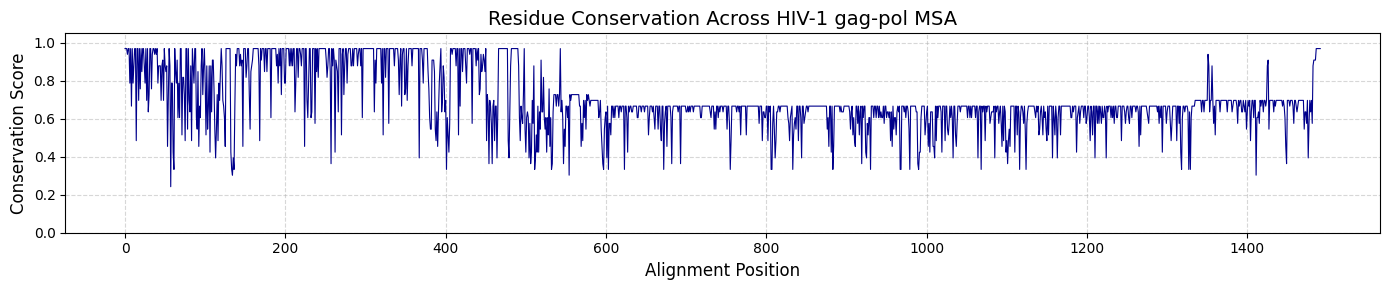

In [40]:
# Load the aligned STO file
alignment = AlignIO.read("hiv1_groupM_gagpol_aligned.sto", "stockholm")

# Calculate conservation score at each position
conservation_scores = []

for i in range(alignment.get_alignment_length()):
    column = alignment[:, i]  # Get all residues at position i
    counts = Counter(column)
    most_common_residue, freq = counts.most_common(1)[0]
    conservation_scores.append(freq / len(alignment))  # Normalize by number of sequences

# Plotting
plt.figure(figsize=(14, 3))
plt.plot(conservation_scores, color='darkblue', linewidth=0.8)
plt.title("Residue Conservation Across HIV-1 gag-pol MSA", fontsize=14)
plt.xlabel("Alignment Position", fontsize=12)
plt.ylabel("Conservation Score", fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The plot above shows the residue conservation score at each position of the multiple sequence alignment. A residue conservation score measures how similar the amino acids are at each aligned position across all sequences. A score of 1.0 means that every sequence has the same amino acid at that position (fully conserved), while lower scores mean there is more variation among the sequences. In this specific scenario for HIV-1 gag-pol polyprotein, positions with low conservation often show where mutations happen more frequently between different virus strains. These variable regions may be linked to how the virus adapts or becomes resistant to treatment. These conserved patterns will help guide the construction of a reliable profile Hidden Markov Model in the next step.

## Step 3: Building a Profile HMM Using HMMER
With our multiple sequence alignment of HIV-1 gag-pol polyproteins complete, we now proceed to build a profile Hidden Markov Model (pHMM) using the tool HMMER. We use the hmmbuild command from the HMMER suite to generate the pHMM from the aligned STO file. The resulting model will serve as a reference for detecting drug resistance mutations by aligning patient-derived sequences to this broader, more representative profile.

In [41]:
# Input and output file paths
aligned_sto = "hiv1_groupM_gagpol_aligned.sto"
output_hmm = "hiv1_gagpol.hmm"

# Command to run HMMER's hmmbuild
command = ["hmmbuild", output_hmm, aligned_sto]

# Run the command and capture output
try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("HMMER build successful.\n")
    print(result.stdout)  # Show summary output from hmmbuild
except subprocess.CalledProcessError as e:
    print("Error running hmmbuild:")
    print(e.stderr)

HMMER build successful.

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             hiv1_groupM_gagpol_aligned.sto
# output HMM file:                  hiv1_gagpol.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     hiv1_groupM_gagpol_aligned    33  1492  1435     0.57  0.588 

# CPU time: 0.20u 0.00s 00:00:00.20 Elapsed: 00:00:00.20



### Step 4: Aligning Translated Patient Reads to the Profile HMM
In this step, we aligned the patient-derived sequencing reads to the previously constructed profile Hidden Markov Model (pHMM) using hmmsearch, which is part of the HMMER tool. Since the pHMM is based on a protein sequence, we first translated the DNA reads into protein sequences in all six possible reading frames using a tool called EMBOSS with its transeq feature. This ensures we capture any potential coding signal, regardless of strand or frame.

We then used hmmsearch to compare these translated reads against the pHMM, allowing us to identify fragments of patient reads that match conserved protein domains within the HIV-1 gag-pol region. This step is crucial for detecting biologically relevant matches and will help in downstream analyses such as variant detection or alignment visualization.

In [42]:
# Use EMBOSS transeq to translate the nucleotide sequence to protein
SeqIO.convert("SRR4071764.fastq", "fastq", "SRR4071764.fasta", "fasta")
subprocess.run(["transeq", "-sequence", "SRR4071764.fasta", "-outseq", "SRR4071764_aa.fasta", "-frame", "6"])

Translate nucleic acid sequences


CompletedProcess(args=['transeq', '-sequence', 'SRR4071764.fasta', '-outseq', 'SRR4071764_aa.fasta', '-frame', '6'], returncode=0)

In [43]:
# Input and output file paths
hmm_model = "hiv1_gagpol.hmm"
translated_reads = "SRR4071764_aa.fasta"
domtblout = "hmmsearch_results.domtbl"
txtout = "hmmsearch_results.txt"

# Run hmmsearch
command = [
    "hmmsearch",
    "--domtblout", domtblout,
    "-o", txtout,
    hmm_model,
    translated_reads
]

try:
    subprocess.run(command, check=True)
    print("hmmsearch completed successfully.")
except subprocess.CalledProcessError as e:
    print("hmmsearch failed:", e.stderr)

hmmsearch completed successfully.


In [44]:
def parse_domtblout(file_path):
    # Store parsed lines
    records = []

    with open(file_path) as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split(maxsplit=22)  # 23 fields expected
            if len(parts) == 23:
                records.append(parts)

    # Convert to DataFrame
    df = pd.DataFrame(records, columns=[
        "target_name", "target_accession", "tlen",
        "query_name", "query_accession", "qlen",
        "E_value", "score", "bias",
        "domain_num", "domain_total",
        "c_Evalue", "i_Evalue", "domain_score", "domain_bias",
        "hmm_from", "hmm_to",
        "ali_from", "ali_to",
        "env_from", "env_to",
        "accuracy", "description_of_target"
    ])

    # Convert numeric columns to appropriate types
    df["E_value"] = df["E_value"].astype(float)
    df["score"] = df["score"].astype(float)
    df["ali_from"] = df["ali_from"].astype(int)
    df["ali_to"] = df["ali_to"].astype(int)

    return df

domtbl_file = "hmmsearch_results.domtbl"
hits_df = parse_domtblout(domtbl_file)

# Preview top hits
hits_df.head()


,target_name,target_accession,tlen,query_name,query_accession,qlen,E_value,score,bias,domain_num,...,domain_score,domain_bias,hmm_from,hmm_to,ali_from,ali_to,env_from,env_to,accuracy,description_of_target
0,SRR4071764.696_1,-,84,hiv1_groupM_gagpol_aligned,-,1435,2.300000e-53,181.4,0.1,1,...,181.3,0.1,661,744,1,84,1,84,0.99,696 length=251
1,SRR4071764.445_6,-,84,hiv1_groupM_gagpol_aligned,-,1435,2.500000e-53,181.3,0.1,1,...,181.2,0.1,662,745,1,84,1,84,0.99,445 length=251
2,SRR4071764.1478_2,-,84,hiv1_groupM_gagpol_aligned,-,1435,3.200000e-53,181.0,0.1,1,...,180.8,0.1,658,740,1,83,1,84,0.99,1478 length=251
3,SRR4071764.1074_1,-,84,hiv1_groupM_gagpol_aligned,-,1435,5.100000e-53,180.3,0.1,1,...,180.1,0.1,656,739,1,84,1,84,0.99,1074 length=251
4,SRR4071764.1004_6,-,84,hiv1_groupM_gagpol_aligned,-,1435,8.200000e-53,179.6,0.1,1,...,179.5,0.1,663,745,1,83,1,84,0.99,1004 length=251


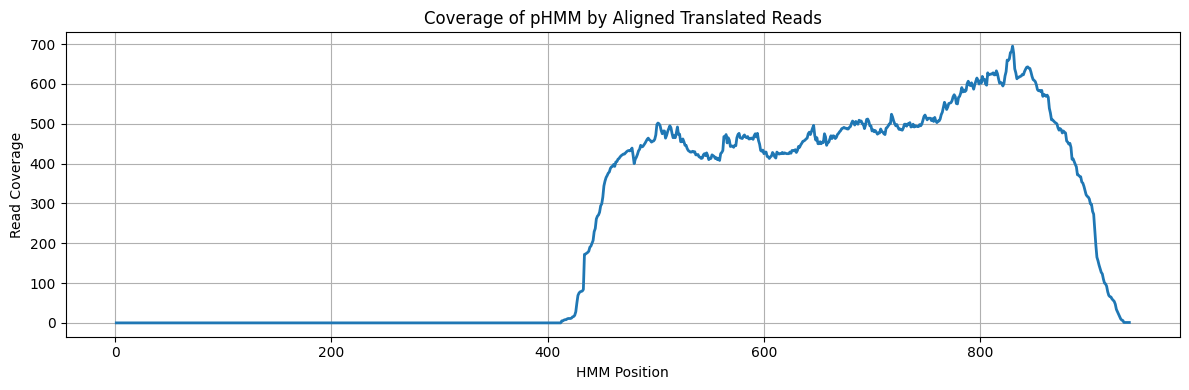

In [45]:

def plot_hmm_coverage(df, hmm_length=None):
    if hmm_length is None:
        hmm_length = df["hmm_to"].astype(int).max()
    
    coverage = np.zeros(hmm_length + 1)

    for _, row in df.iterrows():
        start = int(row["hmm_from"])
        end = int(row["hmm_to"])
        coverage[start:end+1] += 1

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, hmm_length + 1), coverage[1:], linewidth=2)
    plt.title("Coverage of pHMM by Aligned Translated Reads")
    plt.xlabel("HMM Position")
    plt.ylabel("Read Coverage")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

hits_df = parse_domtblout("hmmsearch_results.domtbl")
plot_hmm_coverage(hits_df)

In [46]:
def extract_top_hits(domtbl_file, fasta_file, output_file, evalue_threshold=1e-5):
    # Step 1: Parse domtblout file
    top_hits = set()
    with open(domtbl_file) as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            target_name = parts[0]  # Sequence ID
            evalue = float(parts[6])  # E-value
            if evalue < evalue_threshold:
                top_hits.add(target_name)

    print(f"Found {len(top_hits)} top hits below E-value {evalue_threshold}")

    # Step 2: Extract matching sequences from translated reads
    records = SeqIO.parse(fasta_file, "fasta")
    matched_records = [r for r in records if r.id in top_hits]

    # Step 3: Write to output
    SeqIO.write(matched_records, output_file, "fasta")
    print(f"Saved {len(matched_records)} sequences to {output_file}")

In [ ]:
extract_top_hits(
    domtbl_file="hmmsearch_results.domtbl",
    fasta_file="SRR4071764_aa.fasta",
    output_file="top_hits.fasta",
    evalue_threshold=1e-5
)

Found 3296 top hits below E-value 1e-05
Saved 6592 sequences to top_hits.fasta


In [48]:
# Paths
hmm_file = "hiv1_gagpol.hmm"
reads_file = "top_hits.fasta"
aligned_output = "aligned_reads.sto"

# Run hmmalign
command = [
    "hmmalign",
    "--mapali", "hiv1_groupM_gagpol_aligned.sto",
    "--outformat", "Stockholm",
    "-o", aligned_output,
    hmm_file,
    reads_file
]

try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("hmmalign completed successfully.\n")
    print(result.stdout)  # Optionally show some log output
except subprocess.CalledProcessError as e:
    print("Error running hmmalign:")
    print(e.stderr)

hmmalign completed successfully.




In [49]:
# File path to aligned Stockholm file from hmmalign
alignment_file = "aligned_reads.sto"

# Resistance mutations
resistance_sites = {
    41: ("M", ["L"]),
    67: ("D", ["N"]),
    70: ("K", ["R"]),
    210: ("L", ["W"]),
    215: ("T", ["Y", "F"]),
    219: ("K", ["Q", "E"]),
}

# Load alignment
alignment = AlignIO.read(alignment_file, "stockholm")

# Detect reference/model sequence based on ID format used in Stockholm output
ref_seq_record = next(
    (rec for rec in alignment if "|sp|" in rec.id), None
)

if not ref_seq_record:
    raise ValueError("Reference (model) sequence not found in alignment.")

ref_seq = ref_seq_record.seq
print(f"Reference sequence ID: {ref_seq_record.id}")

Reference sequence ID: 0000|sp|P04588|POL_HV1MA


In [50]:
# Build map from alignment position to reference AA position (excluding gaps)
ref_pos_map = {}
aa_counter = 0
for i, aa in enumerate(ref_seq):
    if aa != "-":
        aa_counter += 1
        ref_pos_map[i] = aa_counter  # alignment index → reference amino acid position

# Reverse map: reference AA pos → alignment index
ref_to_align_index = {v: k for k, v in ref_pos_map.items()}

# Scan all reads for resistance mutations
mutation_counts = defaultdict(int)
mutation_details = []

for record in alignment:
    if record.id.lower().startswith("hmm"):
        continue  # skip model/reference
    
    seq = record.seq
    mutations_in_read = []

    for site, (wild, resist_list) in resistance_sites.items():
        if site not in ref_to_align_index:
            continue  # site missing in this alignment

        align_idx = ref_to_align_index[site]
        if align_idx >= len(seq):
            continue  # truncated

        aa = seq[align_idx]
        if aa in resist_list:
            mutations_in_read.append(f"{wild}{site}{aa}")

    if mutations_in_read:
        for m in mutations_in_read:
            mutation_counts[m] += 1
        mutation_details.append((record.id, mutations_in_read))

# Display mutation summary
print("📊 Resistance Mutation Summary:")
for mutation, count in mutation_counts.items():
    print(f" - {mutation}: {count} reads")

# Optionally show details
print("\n📄 Sample of reads with mutations:")
for read_id, muts in mutation_details[:10]:
    print(f"{read_id}: {', '.join(muts)}")

📊 Resistance Mutation Summary:
 - M41L: 32 reads

📄 Sample of reads with mutations:
0000|sp|P04588|POL_HV1MA: M41L
0001|sp|P24740|POL_HV1U4: M41L
0002|sp|P24736|GAG_HV1U4: M41L
0003|sp|P12498|POL_HV1J3: M41L
0004|sp|P05960|POL_HV1C4: M41L
0005|sp|P03367|POL_HV1BR: M41L
0006|sp|O12158|POL_HV192: M41L
0007|sp|Q75002|POL_HV1ET: M41L
0008|sp|O12157|GAG_HV192: M41L
0009|sp|P18802|POL_HV1ND: M41L


In [52]:
total_reads = sum(1 for record in alignment if not record.id.startswith("hmm"))
mutation_frequencies = {
    mut: count / total_reads for mut, count in mutation_counts.items()
}

print("📊 Resistance Mutation Frequencies:")
for mut, freq in mutation_frequencies.items():
    print(f" - {mut}: {freq:.2%}")


📊 Resistance Mutation Frequencies:
 - M41L: 0.48%


In [54]:
# Map alignment indices to RT codon positions
codon_map = {}
codon_pos = 1
for i, aa in enumerate(ref_seq):
    if aa != '-':
        codon_map[i] = codon_pos
        codon_pos += 1

# Store mutation results
mutation_counts = defaultdict(list)

# Check each patient read
for record in alignment[1:]:  # skip reference
    patient_id = record.id
    seq = str(record.seq)

    for align_idx, rt_pos in codon_map.items():
        if rt_pos in resistance_sites:
            wt_aa, mutations = resistance_sites[rt_pos]
            aa = seq[align_idx]

            if aa in mutations:
                mutation_counts[patient_id].append((rt_pos, wt_aa + "→" + aa))

# Output results
print("Detected AZT Resistance Mutations:\n")
if not mutation_counts:
    print("❌ No AZT resistance mutations detected in aligned reads.")
else:
    for read_id, muts in mutation_counts.items():
        print(f"🔍 {read_id}:")
        for pos, mut in muts:
            print(f"  - Position {pos}: {mut}")
        print()

Detected AZT Resistance Mutations:

🔍 0001|sp|P24740|POL_HV1U4:
  - Position 41: M→L

🔍 0002|sp|P24736|GAG_HV1U4:
  - Position 41: M→L

🔍 0003|sp|P12498|POL_HV1J3:
  - Position 41: M→L

🔍 0004|sp|P05960|POL_HV1C4:
  - Position 41: M→L

🔍 0005|sp|P03367|POL_HV1BR:
  - Position 41: M→L

🔍 0006|sp|O12158|POL_HV192:
  - Position 41: M→L

🔍 0007|sp|Q75002|POL_HV1ET:
  - Position 41: M→L

🔍 0008|sp|O12157|GAG_HV192:
  - Position 41: M→L

🔍 0009|sp|P18802|POL_HV1ND:
  - Position 41: M→L

🔍 0010|sp|P04589|POL_HV1EL:
  - Position 41: M→L

🔍 0012|sp|Q9QBZ5|POL_HV1MP:
  - Position 41: M→L

🔍 0013|sp|O89290|POL_HV193:
  - Position 41: M→L

🔍 0014|sp|Q9QBZ1|POL_HV1M2:
  - Position 41: M→L

🔍 0015|sp|O89940|POL_HV1SE:
  - Position 41: M→L

🔍 0016|sp|O41798|POL_HV19N:
  - Position 41: M→L

🔍 0017|sp|P0C1K7|GAG_HV19N:
  - Position 41: M→L

🔍 0018|sp|Q9Q720|POL_HV1V9:
  - Position 41: M→L

🔍 0019|sp|O93215|POL_HV190:
  - Position 41: M→L

🔍 0020|sp|O93182|GAG_HV190:
  - Position 41: M→L

🔍 0021|sp|Q9WC